# This notebook is a carefully modified version of the celeba tutorial that implements new features (privacy, higher resolution, class splitting) one at a time and tests they are working before moving onto the next task.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms 
from torch.autograd import Variable

# test classes, such as "attractive-brown" are extracted to this path
#dataroot='/home/ben.gelman/celeba/classes'

# all images together are in this dir
dataroot = '/home/ben.gelman/celeba/img_align_celeba'
dataset=datasets.ImageFolder(
    root=dataroot,
    transform=transforms.Compose([
        #remove resizing so we can increase the resolution
        #transforms.Resize(32),
        #transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Pad((0,0,78,38), fill=0, padding_mode='constant')
        ])
        )

dataloader=DataLoader(dataset,num_workers=0,batch_size=64,shuffle=True)

Image dimensions: batch x channels x height x width
Image dimensions: 64 x 3 x 256 x 256


/home/ben.gelman/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  del sys.path[0]


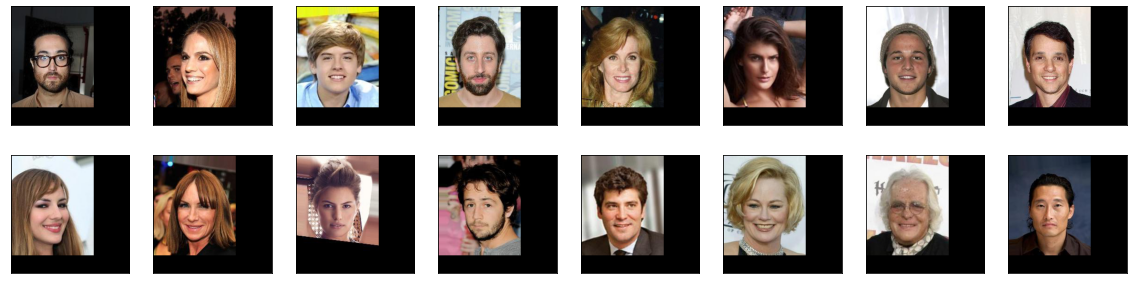

In [2]:
dataiter=iter(dataloader)
images,labels=dataiter.next()

def RGBshow(img):
    img=img.numpy()
    plt.imshow(np.transpose(img,(1,2,0)))

print(f"Image dimensions: batch x channels x height x width")
print(f"Image dimensions: {len(images)} x {len(images[0])} x {len(images[0][0])} x {len(images[0][0][0])}")
plot_only=16
fig=plt.figure(1,figsize=(20,5))
for idx in range(plot_only):
    ax=fig.add_subplot(2,plot_only/2,idx+1,xticks=[],yticks=[])
    RGBshow(images[idx])


In [3]:
def scale(img):
    img=img*2-1
    return img

scaled_img=scale(images[0])
scaled_img.min(),scaled_img.max()

(tensor(-1.), tensor(1.))

In [4]:
def conv(in_channels,out_channels,kernel_size,stride=2,padding=1,batch_norm=True):
    layers=[]
    conv=nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False)

    layers.append(conv)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

def deconv(in_channels,out_channels,kernel_size,stride=2,padding=1,batch_norm=True):
    layers=[]
    transpose_conv=nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,bias=False)

    layers.append(transpose_conv)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

def compute_immediate_sensitivity(model, inp, loss):
    cpu_loss = loss
    # (1) first-order gradient (wrt parameters)
    first_order_grads = torch.autograd.grad(
        cpu_loss,
        model.parameters(),
        retain_graph=True,
        create_graph=True,
        # allow_unused=True
    )

    # (2) L2 norm of the gradient from (1)
    grad_l2_norm = torch.norm(torch.cat([x.view(-1) for x in first_order_grads]), p=2)

    # (3) Gradient (wrt inputs) of the L2 norm of the gradient from (2)
    sensitivity_vec = torch.autograd.grad(grad_l2_norm, inp, retain_graph=True)[0]

    # (4) L2 norm of (3) - "immediate sensitivity"
    # sensitivity = [torch.norm(v, p=2).item() for v in sensitivity_vec]
    sensitivity = torch.norm(
        sensitivity_vec.reshape(sensitivity_vec.shape[0], -1), p=2, dim=1
    )

    return sensitivity

class Discriminator(nn.Module):
    def __init__(self,conv_dim):
        super(Discriminator,self).__init__()
        self.conv_dim=conv_dim

        self.conv1=conv(3,conv_dim,4,batch_norm=False)
        self.conv2=conv(conv_dim,conv_dim*2,4,batch_norm=False)
        self.conv3=conv(conv_dim*2,conv_dim*3,4,batch_norm=False)
        self.conv4=conv(conv_dim*3,conv_dim*4,4,batch_norm=False)

        self.fc=nn.Linear(conv_dim*4*2*2,1)


    def forward(self,x):
        x=F.leaky_relu(self.conv1(x),0.2)
        x=F.leaky_relu(self.conv2(x),0.2)
        x=F.leaky_relu(self.conv3(x),0.2)
        x=F.leaky_relu(self.conv4(x),0.2)
        x = x.view(-1, self.conv_dim*4*2*2)
        out=self.fc(x)
        return out
    
class Generator(nn.Module):
    def __init__(self,z_size,conv_dim):
        super(Generator,self).__init__()
        self.conv_dim=conv_dim
        
        # THIS LINE OF CODE NEEDS TO BE CHANGED BASED ON WHAT YOU WANT YOUR OUTPUT SHAPE TO BE.
        # THE SECOND INPUT TO THIS NN.LINEAR IS THE NUMBER OF PARAMETERS YOU HAVE TO WORK WITH AS YOU
        # BUILD YOUR OUTPUT. So if in the line of code below you have (...,16,16) as the last two inputs
        # to the x.view, then you need to have at least 16*16 parameters in the second input to nn.Linear. 
        self.fc = nn.Linear(z_size,conv_dim*4*16*16)

        '''
        self.deconv1 = deconv(conv_dim*8,conv_dim*4,4)
        self.deconv2 = deconv(conv_dim*4,conv_dim*2,4)
        self.deconv3 = deconv(conv_dim*2,conv_dim,4)
        self.deconv4 = deconv(conv_dim,3,4,batch_norm=False)
        '''
        
        self.deconv1 = nn.ConvTranspose2d(conv_dim*4,conv_dim*3,kernel_size=4,stride=2,padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(conv_dim*3)
        
        self.deconv2 = nn.ConvTranspose2d(conv_dim*3,conv_dim*2,kernel_size=4,stride=2,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(conv_dim*2)
        
        self.deconv3 = nn.ConvTranspose2d(conv_dim*2,conv_dim,kernel_size=4,stride=2,padding=1,bias=False)
        self.bn3 = nn.BatchNorm2d(conv_dim)
        
        self.last_deconv = nn.ConvTranspose2d(conv_dim,3,kernel_size=4,stride=2,padding=1,bias=False)


    def forward(self,x):
        x = self.fc(x)
        
        # This line of code is CRITICAL to the output shape of the model. Those last 2 parameters to the 
        # view determine the initial shape of the image. So every time they get deconvolved, they get upscaled
        # by the stride size of the deconvolutional layer. So, for example, if (...,16,16) are the parameters
        # to the view, and your stride size on your deconvolution is 2, then each deconvolution will change
        # the output shape by a multiple of 2. 16x16 (starting) -> deconvolution,stride=2 -> 32x32 -> 
        # deconvolution,stride=2 -> 64x64 -> deconvolution,stride=2 -> 128x128 -> etc. 
        # NEED TO CHANGE THE self.fc LAYER SIZE ABOVE AS WELL
        x = x.view(-1, self.conv_dim*4, 16, 16)
        '''
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        '''
        
        #deconv1
        x = self.deconv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        #deconv1
        x = self.deconv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        
         #deconv1
        x = self.deconv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        
        #last layer output size specification: shouldn't need the size
        #spec now because i've changed the deconvolving dimensions?
        x = self.last_deconv(x)
        #x = self.last_deconv(x, output_size=torch.Size([128, 3,256,256]))
        out = F.tanh(x)
        return out
    
def weights_init_normal(m):

    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # Applying initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        m.weight.data.normal_(0.0, 0.02)
        
        # The bias terms, if they exist, set to 0
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.data.zero_()

z_size=200
D=Discriminator(96)
G=Generator(z_size,96)

D.apply(weights_init_normal),G.apply(weights_init_normal)

use_cuda=True
if use_cuda and torch.cuda.is_available():
    D.cuda()
    G.cuda()

print(f"{D}\n\n\n{G}\n\n\nGPU on:{use_cuda and torch.cuda.is_available()}")

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(96, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv3): Sequential(
    (0): Conv2d(192, 288, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv4): Sequential(
    (0): Conv2d(288, 384, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (fc): Linear(in_features=1536, out_features=1, bias=True)
)


Generator(
  (fc): Linear(in_features=200, out_features=98304, bias=True)
  (deconv1): ConvTranspose2d(384, 288, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(288, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (

The shapes on the model above can get quite confusing... here's an attempt at an explanation.

The z_dim determines the in_features of the generator, but it seems to only be used at the beginning. I think that z_dim is the size of the random noise given to the generator to work with in order to produce an image. 



In [5]:
def weights_init_normal(m):

    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # Applying initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        m.weight.data.normal_(0.0, 0.02)
        
        # The bias terms, if they exist, set to 0
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.data.zero_()

def real_loss(D_out):
    batch_size = D_out.size(0)
        
    labels = torch.ones(batch_size) * 0.9

    if use_cuda and torch.cuda.is_available():
            labels = labels.cuda()
    criterion=nn.BCEWithLogitsLoss()
    loss=criterion(D_out.squeeze(),labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
        
    labels = torch.ones(batch_size)

    if use_cuda and torch.cuda.is_available():
            labels = labels.cuda()
    criterion=nn.BCEWithLogitsLoss()
    loss=criterion(D_out.squeeze(),labels)
    return loss    
  
  
d_optimizer = optim.Adam(D.parameters(),lr=0.0002,betas=(0.5,0.999))
g_optimizer = optim.Adam(G.parameters(),lr=0.0002,betas=(0.5,0.999))

In [6]:
import pickle as pkl
import time

def train(D, G, n_epochs, print_every=300, dp_training=False, alpha=2, epsilon=1e5):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    start = time.time()
    
    # move models to GPU
    if use_cuda and torch.cuda.is_available():
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if use_cuda and torch.cuda.is_available():
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(dataloader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            d_optimizer.zero_grad()
            
            '''
            # DP step 1: prepare data
            if dp_training:
                real_images = Variable(real_images, requires_grad=True)
            '''
            
            if use_cuda and torch.cuda.is_available():
                real_images = real_images.cuda()
                
            # 1. Train the discriminator on real and fake images
            
            # Compute the discriminator losses on real images
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            '''
            # DP step 2: call sensitivity computation
            if dp_training:
                batch_sensitivities = compute_immediate_sensitivity(
                    D, real_images, d_real_loss
                )
                batch_sensitivity = torch.max(batch_sensitivities) / len(real_images)
            '''
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if use_cuda and torch.cuda.is_available():
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if use_cuda and torch.cuda.is_available():
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images 
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)
            
            # perfom backprop
            g_loss.backward()
            g_optimizer.step()


            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f} | time: {:f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item(), time.time()-start))

        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        # Save training generator samples
        with open(f'samples/moddp/train_samples_epoch{epoch}.pkl', 'wb') as f:
            pkl.dump([samples_z], f)
        G.train() # back to training mode

    
    # finally return losses
    return losses
  
  

n_epochs = 50

'''
dp_training = True
losses = train(D, G, n_epochs=n_epochs, dp_training=dp_training, alpha=, epsilon=)
'''

# call training function
losses = train(D, G, n_epochs=n_epochs)

/home/ben.gelman/.local/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/   75] | d_loss: 1.3849 | g_loss: 0.6880 | time: 0.923955
Epoch [    1/   75] | d_loss: 0.4615 | g_loss: 0.3593 | time: 215.565726
Epoch [    1/   75] | d_loss: 0.5522 | g_loss: 0.3323 | time: 441.280675
Epoch [    1/   75] | d_loss: 0.4996 | g_loss: 0.3529 | time: 660.770295
Epoch [    1/   75] | d_loss: 0.5113 | g_loss: 0.3371 | time: 878.944677
Epoch [    1/   75] | d_loss: 0.5169 | g_loss: 0.3294 | time: 1098.050014
Epoch [    1/   75] | d_loss: 0.5069 | g_loss: 0.3311 | time: 1317.723103
Epoch [    1/   75] | d_loss: 0.5259 | g_loss: 0.3340 | time: 1536.468868
Epoch [    1/   75] | d_loss: 0.5308 | g_loss: 0.3329 | time: 1755.474847
Epoch [    1/   75] | d_loss: 0.5501 | g_loss: 0.3279 | time: 1973.649990
Epoch [    1/   75] | d_loss: 0.5085 | g_loss: 0.3270 | time: 2191.715526
Epoch [    2/   75] | d_loss: 0.5235 | g_loss: 0.3350 | time: 2312.530950
Epoch [    2/   75] | d_loss: 0.5255 | g_loss: 0.3285 | time: 2531.874603
Epoch [    2/   75] | d_loss: 0.6806 | g_loss

Epoch [   11/   75] | d_loss: 0.3961 | g_loss: 0.3486 | time: 23151.613904
Epoch [   11/   75] | d_loss: 0.3965 | g_loss: 0.3472 | time: 23370.551084
Epoch [   11/   75] | d_loss: 0.3955 | g_loss: 0.3488 | time: 23589.572165
Epoch [   11/   75] | d_loss: 0.3969 | g_loss: 0.3465 | time: 23809.541443
Epoch [   11/   75] | d_loss: 0.3953 | g_loss: 0.3471 | time: 24030.432063
Epoch [   11/   75] | d_loss: 0.3961 | g_loss: 0.3500 | time: 24250.286314
Epoch [   11/   75] | d_loss: 0.3941 | g_loss: 0.3525 | time: 24467.916915
Epoch [   11/   75] | d_loss: 0.4037 | g_loss: 0.3423 | time: 24690.379367
Epoch [   11/   75] | d_loss: 0.4003 | g_loss: 0.3463 | time: 24912.230364
Epoch [   11/   75] | d_loss: 0.3973 | g_loss: 0.3468 | time: 25132.044960
Epoch [   11/   75] | d_loss: 0.3981 | g_loss: 0.3475 | time: 25350.846043
Epoch [   12/   75] | d_loss: 0.3984 | g_loss: 0.3478 | time: 25471.332168
Epoch [   12/   75] | d_loss: 0.3978 | g_loss: 0.3457 | time: 25688.181689
Epoch [   12/   75] | d_l

Epoch [   21/   75] | d_loss: 0.3819 | g_loss: 0.3738 | time: 46281.624253
Epoch [   21/   75] | d_loss: 0.3959 | g_loss: 0.3469 | time: 46500.013982
Epoch [   21/   75] | d_loss: 0.4026 | g_loss: 0.3515 | time: 46717.959696
Epoch [   21/   75] | d_loss: 0.3909 | g_loss: 0.3856 | time: 46938.882108
Epoch [   21/   75] | d_loss: 0.3828 | g_loss: 0.3675 | time: 47157.185352
Epoch [   21/   75] | d_loss: 0.4082 | g_loss: 0.3704 | time: 47375.753424
Epoch [   21/   75] | d_loss: 0.3813 | g_loss: 0.3636 | time: 47593.509073
Epoch [   21/   75] | d_loss: 0.3842 | g_loss: 0.3773 | time: 47811.809309
Epoch [   21/   75] | d_loss: 0.3760 | g_loss: 0.3769 | time: 48033.468163
Epoch [   21/   75] | d_loss: 0.3972 | g_loss: 0.3478 | time: 48256.937068
Epoch [   21/   75] | d_loss: 0.3899 | g_loss: 0.3575 | time: 48478.727503
Epoch [   22/   75] | d_loss: 0.3895 | g_loss: 0.3491 | time: 48600.440919
Epoch [   22/   75] | d_loss: 0.3847 | g_loss: 0.3749 | time: 48821.020156
Epoch [   22/   75] | d_l

Epoch [   31/   75] | d_loss: 0.3814 | g_loss: 0.4227 | time: 69362.804796
Epoch [   31/   75] | d_loss: 0.3730 | g_loss: 0.3892 | time: 69579.624196
Epoch [   31/   75] | d_loss: 0.3912 | g_loss: 0.3582 | time: 69797.241142
Epoch [   31/   75] | d_loss: 0.3744 | g_loss: 0.3759 | time: 70014.267661
Epoch [   31/   75] | d_loss: 0.3730 | g_loss: 0.4099 | time: 70230.603377
Epoch [   31/   75] | d_loss: 0.3742 | g_loss: 0.3626 | time: 70447.276905
Epoch [   31/   75] | d_loss: 0.3771 | g_loss: 0.3657 | time: 70663.980023
Epoch [   31/   75] | d_loss: 0.3764 | g_loss: 0.3591 | time: 70881.761829
Epoch [   31/   75] | d_loss: 0.3940 | g_loss: 0.3590 | time: 71098.491790
Epoch [   31/   75] | d_loss: 0.3728 | g_loss: 0.3764 | time: 71316.054042
Epoch [   31/   75] | d_loss: 0.3719 | g_loss: 0.3895 | time: 71533.400764
Epoch [   32/   75] | d_loss: 0.3720 | g_loss: 0.3857 | time: 71655.279834
Epoch [   32/   75] | d_loss: 0.3725 | g_loss: 0.3969 | time: 71871.759171
Epoch [   32/   75] | d_l

Epoch [   41/   75] | d_loss: 0.3718 | g_loss: 0.3833 | time: 92334.727462
Epoch [   41/   75] | d_loss: 0.3716 | g_loss: 0.3757 | time: 92552.619629
Epoch [   41/   75] | d_loss: 0.3710 | g_loss: 0.4351 | time: 92769.577351
Epoch [   41/   75] | d_loss: 0.3770 | g_loss: 0.3622 | time: 92985.843268
Epoch [   41/   75] | d_loss: 0.3678 | g_loss: 0.3919 | time: 93206.854116
Epoch [   41/   75] | d_loss: 0.3659 | g_loss: 0.3885 | time: 93423.826495
Epoch [   41/   75] | d_loss: 0.3707 | g_loss: 0.3980 | time: 93641.310409
Epoch [   41/   75] | d_loss: 0.3745 | g_loss: 0.4348 | time: 93859.238333
Epoch [   41/   75] | d_loss: 0.3660 | g_loss: 0.3813 | time: 94080.546850
Epoch [   41/   75] | d_loss: 0.3654 | g_loss: 0.3931 | time: 94297.044480
Epoch [   41/   75] | d_loss: 0.3675 | g_loss: 0.3783 | time: 94513.367617
Epoch [   42/   75] | d_loss: 0.3744 | g_loss: 0.3713 | time: 94633.135092
Epoch [   42/   75] | d_loss: 0.3809 | g_loss: 0.3676 | time: 94849.758152
Epoch [   42/   75] | d_l

Epoch [   50/   75] | d_loss: 0.3593 | g_loss: 0.4408 | time: 115159.013095
Epoch [   51/   75] | d_loss: 0.3622 | g_loss: 0.4102 | time: 115279.088552
Epoch [   51/   75] | d_loss: 0.3613 | g_loss: 0.4088 | time: 115496.135402
Epoch [   51/   75] | d_loss: 0.3661 | g_loss: 0.3954 | time: 115713.487317
Epoch [   51/   75] | d_loss: 0.3571 | g_loss: 0.4261 | time: 115933.170405
Epoch [   51/   75] | d_loss: 0.3590 | g_loss: 0.4081 | time: 116149.953312
Epoch [   51/   75] | d_loss: 0.3622 | g_loss: 0.4076 | time: 116367.455338
Epoch [   51/   75] | d_loss: 0.3618 | g_loss: 0.4197 | time: 116587.245901
Epoch [   51/   75] | d_loss: 0.3581 | g_loss: 0.4330 | time: 116803.936656
Epoch [   51/   75] | d_loss: 0.3711 | g_loss: 0.3858 | time: 117020.868637
Epoch [   51/   75] | d_loss: 0.3618 | g_loss: 0.3963 | time: 117237.801126
Epoch [   51/   75] | d_loss: 0.3695 | g_loss: 0.4249 | time: 117459.961021
Epoch [   52/   75] | d_loss: 0.3772 | g_loss: 0.3756 | time: 117579.996770
Epoch [   52

KeyboardInterrupt: 

NameError: name 'losses' is not defined

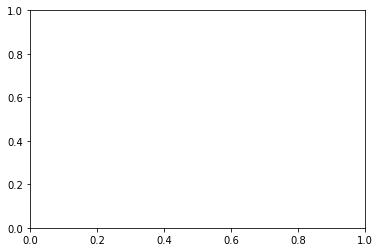

In [7]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

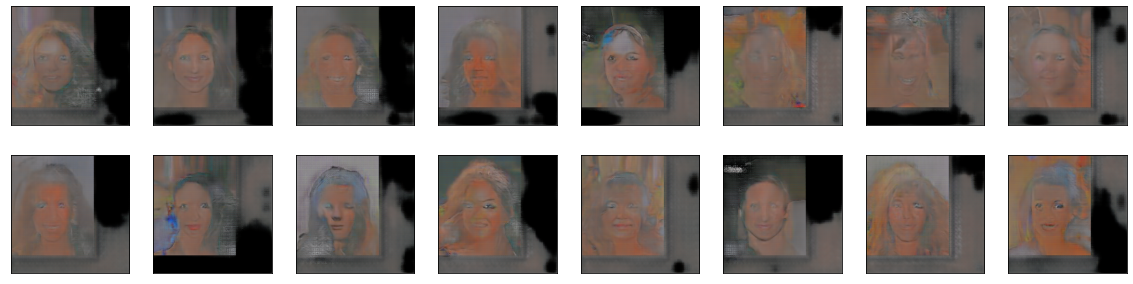

In [18]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch):
    with open(f'samples/moddp/train_samples_epoch{epoch}.pkl', 'rb') as f:
        samples = pkl.load(f)
    
    fig, axes = plt.subplots(figsize=(20,5), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[0]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((256,256,3)))
        #im = ax.imshow(img.reshape((32,32,3)))
        

# Load samples from generator, taken while training
view_samples(55)

# Shape testing to learn how deconvolutions work

In [ ]:
'''
z = np.random.uniform(-1, 1, size=(64, z_size))
z = torch.from_numpy(z).float()
z=z.cuda()
result = G(z)
print(f"Dimensions: {len(result)} x {len(result[0])} x {len(result[0][0])} x {len(result[0][0][0])}")

# With square kernels and equal stride
m = nn.ConvTranspose2d(256, 3, 4, stride=2, padding=1)
inp = torch.randn(128, 256, 50, 100)
output = m(inp)
print(f"Dimensions: {len(output)} x {len(output[0])} x {len(output[0][0])} x {len(output[0][0][0])}")

# exact output size can be also specified as an argument
inp = torch.randn(1, 16, 12, 12)
downsample = nn.Conv2d(16, 16, 3, stride=2, padding=1)
upsample = nn.ConvTranspose2d(16, 16, 3, stride=2, padding=1)
h = downsample(inp)
print(h.size())
#torch.Size([1, 16, 6, 6])
output = upsample(h, output_size=inp.size())
print(inp.size())
print(output.size())
#torch.Size([1, 16, 12, 12])
'''